In [1]:
# For metadata/feature processing
import numpy as np
import pandas as pd
from glob import glob
from tqdm.notebook import tqdm

# For neural network
import tensorflow as tf

# For Accuracy metric
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# For image
import cv2
import matplotlib.pyplot as plt

import os
import seaborn as sns
import albumentations as A
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


2025-08-01 12:03:21.614078: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754049801.962684      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754049802.059287      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import os
import numpy as np
import tensorflow as tf
import random

SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'  # Force TensorFlow to use deterministic algorithms

np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)


In [3]:
sp_paths = glob('/kaggle/input/pd-hw-data/dataset/spiral/training/*/*png')
print(f"Num Train: {len(sp_paths)}")

sp_test_paths = glob('/kaggle/input/pd-hw-data/dataset/spiral/testing/*/*png')
print(f"Num Test: {len(sp_test_paths)}")

wv_paths = glob('/kaggle/input/pd-hw-data/dataset/wave/training/*/*png')
print(f"Num Train: {len(wv_paths)}")

wv_test_paths = glob('/kaggle/input/pd-hw-data/dataset/wave/testing/*/*png')
print(f"Num Test: {len(wv_test_paths)}")

Num Train: 72
Num Test: 30
Num Train: 72
Num Test: 30


In [4]:
print('Train:')
sp_df = pd.DataFrame(sp_paths, columns=['spiral_image_path'])
wv_df = pd.DataFrame(wv_paths, columns=['wave_image_path'])
display(sp_df.head(2))
display(wv_df.head(2))

print('Test:')
sp_test = pd.DataFrame(sp_test_paths, columns=['spiral_image_path'])
wv_test = pd.DataFrame(wv_test_paths, columns=['wave_image_path'])
display(sp_test.head(2))
display(wv_test.head(2))

Train:


,spiral_image_path
0,/kaggle/input/pd-hw-data/dataset/spiral/traini...
1,/kaggle/input/pd-hw-data/dataset/spiral/traini...


,wave_image_path
0,/kaggle/input/pd-hw-data/dataset/wave/training...
1,/kaggle/input/pd-hw-data/dataset/wave/training...


Test:


,spiral_image_path
0,/kaggle/input/pd-hw-data/dataset/spiral/testin...
1,/kaggle/input/pd-hw-data/dataset/spiral/testin...


,wave_image_path
0,/kaggle/input/pd-hw-data/dataset/wave/testing/...
1,/kaggle/input/pd-hw-data/dataset/wave/testing/...


In [5]:


# Merge spiral, wave and label into a single DataFrame
train_df = pd.concat([sp_df, wv_df], axis=1)
display(train_df.head(2))


test = pd.concat([sp_test, wv_test], axis=1)
display(test.head(2))



,spiral_image_path,wave_image_path
0,/kaggle/input/pd-hw-data/dataset/spiral/traini...,/kaggle/input/pd-hw-data/dataset/wave/training...
1,/kaggle/input/pd-hw-data/dataset/spiral/traini...,/kaggle/input/pd-hw-data/dataset/wave/training...


,spiral_image_path,wave_image_path
0,/kaggle/input/pd-hw-data/dataset/spiral/testin...,/kaggle/input/pd-hw-data/dataset/wave/testing/...
1,/kaggle/input/pd-hw-data/dataset/spiral/testin...,/kaggle/input/pd-hw-data/dataset/wave/testing/...


In [6]:
# First we map the class name from the image paths, similar to how it is done in the above code
# Train
train_df['class_name'] = train_df.spiral_image_path.map(lambda x: x.split('/')[-2]) # extract class

display(train_df.head(3))

# Test
test['class_name'] = test.spiral_image_path.map(lambda x: x.split('/')[-2]) # extract class

display(test.head(3))

,spiral_image_path,wave_image_path,class_name
0,/kaggle/input/pd-hw-data/dataset/spiral/traini...,/kaggle/input/pd-hw-data/dataset/wave/training...,healthy
1,/kaggle/input/pd-hw-data/dataset/spiral/traini...,/kaggle/input/pd-hw-data/dataset/wave/training...,healthy
2,/kaggle/input/pd-hw-data/dataset/spiral/traini...,/kaggle/input/pd-hw-data/dataset/wave/training...,healthy


,spiral_image_path,wave_image_path,class_name
0,/kaggle/input/pd-hw-data/dataset/spiral/testin...,/kaggle/input/pd-hw-data/dataset/wave/testing/...,healthy
1,/kaggle/input/pd-hw-data/dataset/spiral/testin...,/kaggle/input/pd-hw-data/dataset/wave/testing/...,healthy
2,/kaggle/input/pd-hw-data/dataset/spiral/testin...,/kaggle/input/pd-hw-data/dataset/wave/testing/...,healthy


In [7]:
name2label = {k: v for v, k in enumerate(sorted(train_df['class_name'].unique()))}
name2label

{'healthy': 0, 'parkinson': 1}

In [8]:
label2name = {v: k for k, v in name2label.items()}
label2name

{0: 'healthy', 1: 'parkinson'}

In [9]:
# transforming the labels
train_df['class_label'] = train_df['class_name'].map(name2label)
display(train_df.head(2))

# transforming the labels
test['class_label'] = test['class_name'].map(name2label)
display(test.head(2))

,spiral_image_path,wave_image_path,class_name,class_label
0,/kaggle/input/pd-hw-data/dataset/spiral/traini...,/kaggle/input/pd-hw-data/dataset/wave/training...,healthy,0
1,/kaggle/input/pd-hw-data/dataset/spiral/traini...,/kaggle/input/pd-hw-data/dataset/wave/training...,healthy,0


,spiral_image_path,wave_image_path,class_name,class_label
0,/kaggle/input/pd-hw-data/dataset/spiral/testin...,/kaggle/input/pd-hw-data/dataset/wave/testing/...,healthy,0
1,/kaggle/input/pd-hw-data/dataset/spiral/testin...,/kaggle/input/pd-hw-data/dataset/wave/testing/...,healthy,0


In [10]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.33, random_state=42)
for val_idx, test_idx in sss.split(test, test['class_label']):
    valid_df = test.iloc[val_idx]
    test_df = test.iloc[test_idx]

print(f"Train: {len(train_df)}")
print(f"Test: {len(test_df)}")
print(f"Valid: {len(valid_df)}")

Train: 72
Test: 10
Valid: 20


In [11]:
train_spiral_paths = train_df['spiral_image_path'].tolist()
train_wave_paths = train_df['wave_image_path'].tolist()
train_labels = train_df['class_label'].tolist()

valid_spiral_paths = valid_df['spiral_image_path'].tolist()
valid_wave_paths = valid_df['wave_image_path'].tolist()
valid_labels = valid_df['class_label'].tolist()

test_spiral_paths = test_df['spiral_image_path'].tolist()
test_wave_paths = test_df['wave_image_path'].tolist()
test_labels = test_df['class_label'].tolist()


In [12]:
# STEP 2: DataLoader for Dual Inputs
# -------------------------------

class DualInputDataLoader(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size=14, dim=(256, 256), shuffle=True, augment=False):
        self.df = df.reset_index(drop=True)
        self.batch_size = batch_size
        self.dim = dim
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()

        self.augment_fn = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.Rotate(limit=20, p=0.7)
        ]) if augment else None

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        batch_df = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size]
        return self.__data_generation(batch_df)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __data_generation(self, batch_df):
        spiral_imgs = np.empty((len(batch_df), *self.dim, 1), dtype=np.float32)
        wave_imgs = np.empty((len(batch_df), *self.dim, 1), dtype=np.float32)
        labels = np.empty((len(batch_df),), dtype=np.float32)

        for i, (_, row) in enumerate(batch_df.iterrows()):
            spiral = cv2.imread(row['spiral_image_path'], cv2.IMREAD_GRAYSCALE)
            wave = cv2.imread(row['wave_image_path'], cv2.IMREAD_GRAYSCALE)

            spiral = cv2.resize(255 - spiral, self.dim)
            wave = cv2.resize(255 - wave, self.dim)

            if self.augment_fn:
                spiral = self.augment_fn(image=spiral)['image']
                wave = self.augment_fn(image=wave)['image']

            spiral_imgs[i, ..., 0] = spiral.astype(np.float32) / 255.0
            wave_imgs[i, ..., 0] = wave.astype(np.float32) / 255.0
            labels[i] = row['class_label']

        return {"spiral": spiral_imgs, "wave": wave_imgs}, labels.reshape(-1, 1)


In [13]:
# STEP 3: Dual-Input CNN Model
# -------------------------------

def create_dual_input_model(input_shape=(256, 256, 1)):
    def build_branch(name):
        inp = layers.Input(shape=input_shape, name=name)
        x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inp)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Flatten()(x)
        x = layers.Dense(128, activation='relu')(x)
        return inp, x

    input_spiral, out_spiral = build_branch("spiral")
    input_wave, out_wave = build_branch("wave")

    combined = layers.Concatenate()([out_spiral, out_wave])
    x = layers.Dense(128, activation='relu')(combined)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs=[input_spiral, input_wave], outputs=output)
    return model


In [14]:
# STEP 4: Prepare Data Loaders & Compile
# -------------------------------

train_loader = DualInputDataLoader(train_df, augment=True)
val_loader = DualInputDataLoader(valid_df)
test_loader = DualInputDataLoader(test_df)

model = create_dual_input_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

ckpt_cb = ModelCheckpoint("best_dual_model.h5", monitor='val_accuracy', save_best_only=True)
early_cb = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

I0000 00:00:1754049826.234968      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1754049826.235670      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [15]:
# STEP 5: Train
# -------------------------------

try:
    history = model.fit(
        train_loader,
        validation_data=val_loader,
        epochs=50,
        callbacks=[ckpt_cb, early_cb]
    )
except Exception as e:
    print(f"Training failed: {e}")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1754049833.585199      98 cuda_dnn.cc:529] Loaded cuDNN version 90300


6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 885ms/step - accuracy: 0.4791 - loss: 0.8664 - val_accuracy: 0.5000 - val_loss: 0.6903
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 553ms/step - accuracy: 0.6068 - loss: 0.6867 - val_accuracy: 0.5500 - val_loss: 0.6903
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 250ms/step - accuracy: 0.5292 - loss: 0.6920 - val_accuracy: 0.5000 - val_loss: 0.6921
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 554ms/step - accuracy: 0.6349 - loss: 0.6811 - val_accuracy: 0.6500 - val_loss: 0.6826
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 602ms/step - accuracy: 0.4513 - loss: 0.7039 - val_accuracy: 0.7000 - val_loss: 0.6749
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 279ms/step - accuracy: 0.6776 - loss: 0.6733 - val_accuracy: 0.7000 - val_loss: 0.6646
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 268ms/step - accuracy: 0.6336 - loss: 0.6616 - val_accuracy: 0.6500 - val_loss: 0.6182
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 543ms/step - accuracy: 0.6956 - loss: 0.5827 - val_accuracy: 0.7500 - val_loss: 0.5531
Ep

## Inference on Validation Set
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step

## Accuracy: 0.7500

Classification Report:
              precision    recall  f1-score   support

     healthy       0.78      0.70      0.74        10
   parkinson       0.73      0.80      0.76        10

    accuracy                           0.75        20
   macro avg       0.75      0.75      0.75        20
weighted avg       0.75      0.75      0.75        20



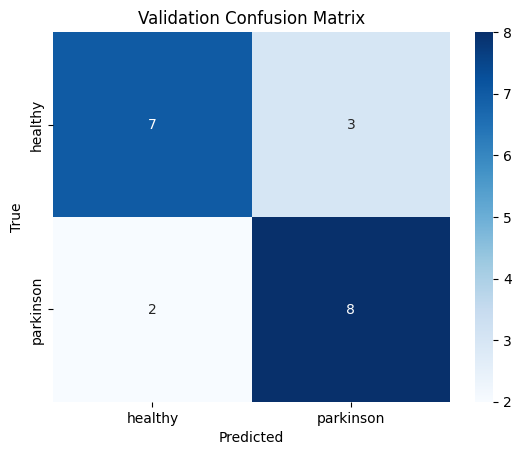

In [16]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Reload best model if needed
model = tf.keras.models.load_model("best_dual_model.h5")

# Create validation data loader (if not already created)
val_loader = DualInputDataLoader(valid_df, shuffle=False)

# Inference
print("## Inference on Validation Set")
pred_probs = model.predict(val_loader)
pred_labels = (pred_probs > 0.5).astype(int).flatten()
y_true = valid_df['class_label'].values

# Accuracy
acc = accuracy_score(y_true, pred_labels)
print(f"\n## Accuracy: {acc:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, pred_labels, target_names=['healthy', 'parkinson']))

# Confusion Matrix
cm = confusion_matrix(y_true, pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['healthy', 'parkinson'], yticklabels=['healthy', 'parkinson'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Validation Confusion Matrix')
plt.show()


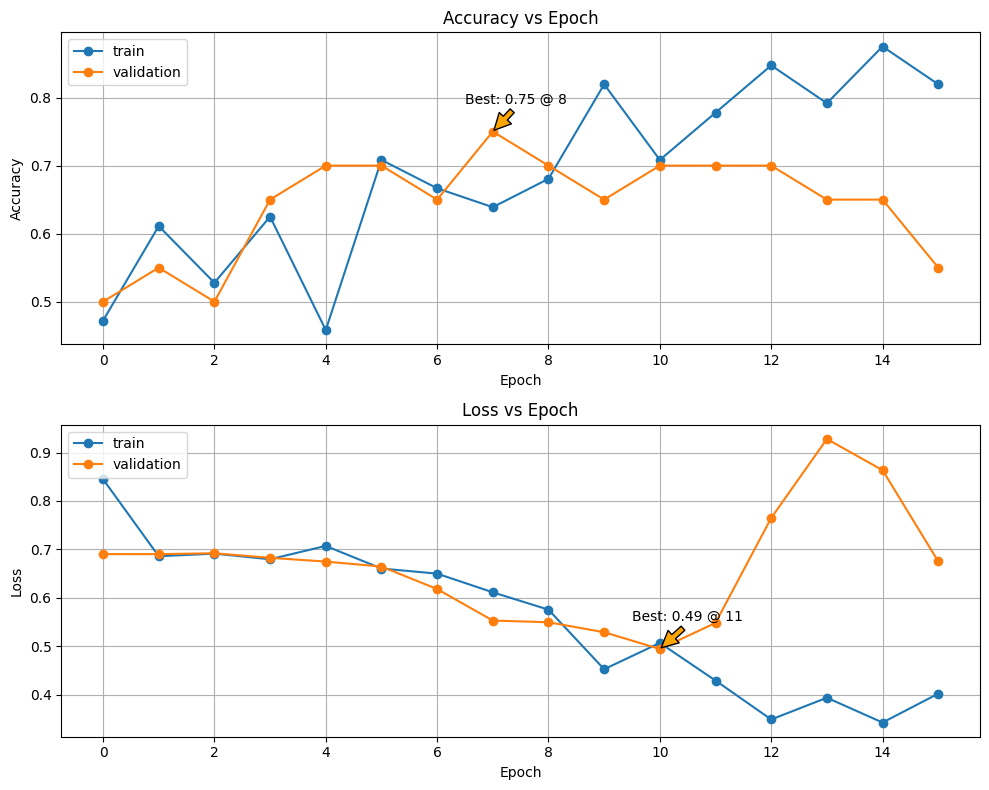

In [17]:

# Step 10: Training History Plot
def plot_history(history):
    plt.figure(figsize=(10, 8))

    plt.subplot(2, 1, 1)
    plt.plot(history.history['accuracy'], '-o')
    plt.plot(history.history['val_accuracy'], '-o')
    plt.title('Accuracy vs Epoch')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.grid(True)

    best_val_acc = max(history.history['val_accuracy'])
    best_epoch = np.argmax(history.history['val_accuracy'])
    plt.annotate(f'Best: {best_val_acc:.2f} @ {best_epoch+1}',
                 xy=(best_epoch, best_val_acc),
                 xytext=(-20, 20),
                 textcoords='offset points',
                 arrowprops=dict(facecolor='orange', shrink=0.05),
                 fontsize=10, color='black')

    plt.subplot(2, 1, 2)
    plt.plot(history.history['loss'], '-o')
    plt.plot(history.history['val_loss'], '-o')
    plt.title('Loss vs Epoch')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.grid(True)

    best_val_loss = min(history.history['val_loss'])
    best_loss_epoch = np.argmin(history.history['val_loss'])
    plt.annotate(f'Best: {best_val_loss:.2f} @ {best_loss_epoch+1}',
                 xy=(best_loss_epoch, best_val_loss),
                 xytext=(-20, 20),
                 textcoords='offset points',
                 arrowprops=dict(facecolor='orange', shrink=0.05),
                 fontsize=10, color='black')

    plt.tight_layout()
    plt.show()

plot_history(history)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
Test Classification Report:
              precision    recall  f1-score   support

     Healthy       0.67      0.80      0.73         5
   Parkinson       0.75      0.60      0.67         5

    accuracy                           0.70        10
   macro avg       0.71      0.70      0.70        10
weighted avg       0.71      0.70      0.70        10



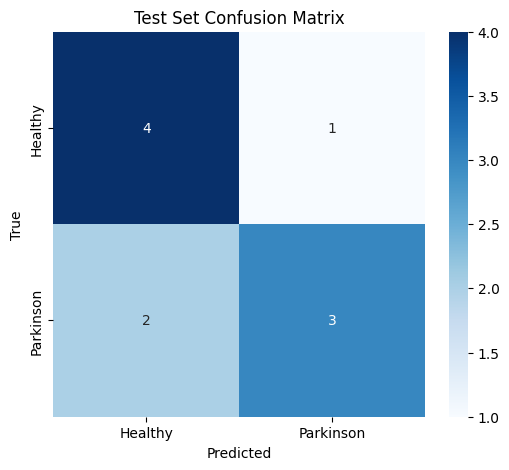

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


2025-08-01 12:04:31.752366: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


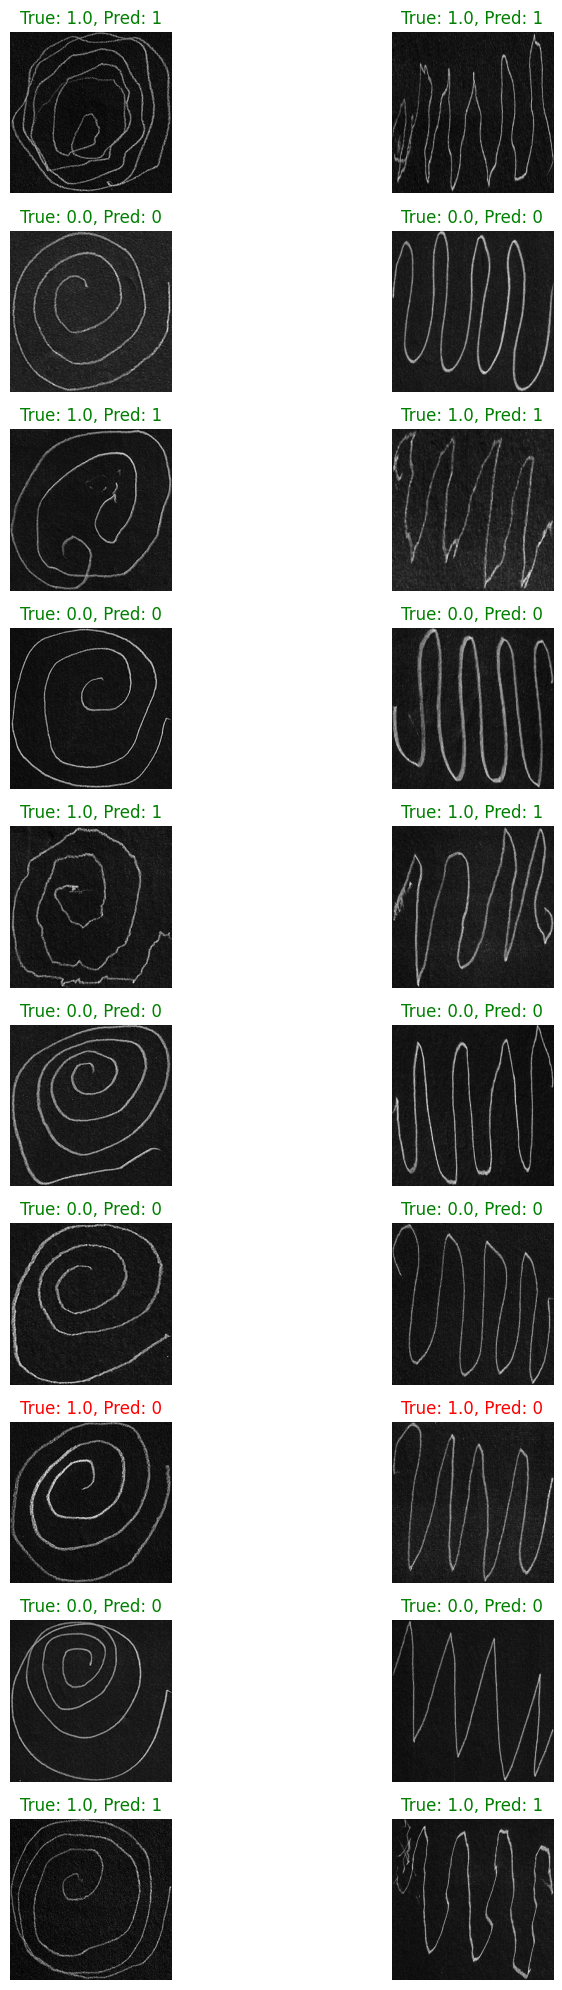

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# STEP 6: Evaluate
# -------------------------------
# Get the true labels and predicted labels
y_true = np.array(test_labels)
y_pred = model.predict(test_loader)
y_pred = (y_pred > 0.5).astype(int).flatten()

# Print the classification report
print("Test Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Healthy', 'Parkinson']))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Parkinson'], yticklabels=['Healthy', 'Parkinson'])
plt.title("Test Set Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Visualizing results for a few samples (e.g., 10 samples)
imgs, tars = test_loader.__getitem__(0)
preds = model.predict(imgs)
preds = preds.ravel()
labels = (preds > 0.5).astype(int)

num_samples = 10

# Create subplots for displaying spiral and wave images
fig, axes = plt.subplots(num_samples, 2, figsize=(10, 20))  # 2 columns for spiral and wave images

for i in range(num_samples):
    # For spiral image
    ax1 = axes[i, 0]
    ax1.imshow(imgs["spiral"][i].squeeze(), cmap='gray')  # Access spiral images using "spiral"
    ax1.set_title(f"True: {tars[i][0]}, Pred: {labels[i]}")
    ax1.axis('off')  # Hide axes for better image clarity

    # For wave image
    ax2 = axes[i, 1]
    ax2.imshow(imgs["wave"][i].squeeze(), cmap='gray')  # Access wave images using "wave"
    ax2.set_title(f"True: {tars[i][0]}, Pred: {labels[i]}")
    ax2.axis('off')  # Hide axes for better image clarity

    # Color title based on correct or incorrect prediction
    if labels[i] == tars[i][0]:
        ax1.set_title(f"True: {tars[i][0]}, Pred: {labels[i]}", color='green')
        ax2.set_title(f"True: {tars[i][0]}, Pred: {labels[i]}", color='green')
    else:
        ax1.set_title(f"True: {tars[i][0]}, Pred: {labels[i]}", color='red')
        ax2.set_title(f"True: {tars[i][0]}, Pred: {labels[i]}", color='red')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()
